In [2]:
!pip install pykrev

     ------------------------------------ 119.9/119.9 kB 702.7 kB/s eta 0:00:00


**How to use this guide**: 

* The guide is split up into three sections. 
    * Part 1: Formula: reading in data and basic formula manipulation. 
    * ★ Part 2 ★ : Plotting: plotting van krevelen diagrams, histograms and other visualisations. 
    * Part 3: Diversity and multivariate analysis: performing statistical analysis on data and calculating chemical diversity.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pykrev as pk

<h3> Part 1: Basic formula manipulation </h3>

1.1: PyKrev uses two data types. An ```msTuple``` is used to analyse a single peak list, and an ```msTupleDict``` is used to analyse multiple peak lists. <br>
   * An ```msTuple``` is a [tuple](https://www.w3schools.com/python/python_tuples.asp) containing three objects in the following order:
      * (1) An list of molecular formula strings. 
         * Molecular formula strings should be written in the form $C_{C}H_{H}Cl_{Cl}F_{F}N_{N}O_{O}P_{P}S_{S}$.  
         * $C_{6}H_{12}O_{6}$ would be written 'C6H12O6'.
         * PyKrev cannot parse isotopologue formula strings (e.g. C9H12O6 13C1).
         * Currently PyKrev only supports formulae with C,H,N,O,P,S,Cl and F assignments.
      * (2) An numpy.ndarray of corresponding peak intensities
      * (3) An numpy.ndarray of corresponding calibrated m/z values <br><br>
   * An ```msTupleDict``` is a [dictionary](https://www.w3schools.com/python/python_dictionaries.asp) containing sample names as keys and ```msTuples``` as values.<br><br>

In [3]:
#Read an assigned peak list from a .csv file
A = pk.read_csv('data/example_A.csv', column_headers = True) 
B  = pk.read_csv('data/example_B.csv', column_headers = True)
C = pk.read_csv('data/example_C.csv', column_headers = True)

#A is an msTuple
print(type(A))
#A.formula is a list
print(type(A.formula))
#A intensity, and A.mz are numpy.ndarrays
print(type(A.intensity))
print()
#We can summarise the objects in A 
A.summary()

<class 'pykrev.formula.msTuple.msTuple'>
<class 'list'>
<class 'numpy.ndarray'>

assigned formula = 3333 
min intensity = 8.3E+05
max intensity = 6.2E+09
mean mz = 534.5778631953195 
std mz = 1.9E+02


In [4]:
A

msTuple(formula=['C6H6O2' 'C5H6O3' 'C4H6O4' ... 'C51H24N2O60' 'C96H163N1O20'
 'C104H174N2O19']), intensity=[ 894212  999389 1126322 ... 2116782 2465203 2310559], mz=[ 109.02949  113.02443  117.01935 ... 1622.88107 1649.16948 1754.26396]

In [5]:
#Read in a batch alignment formularity file
msTupleDict = pk.read_batch_formularity('data/batch_formularity.csv')
#This produces am msTupleDict in which sample names are keys and corresponding msTuples are values
D = msTupleDict['SAMPLE D']
D.summary()

assigned formula = 761 
min intensity = 2.4E+06
max intensity = 1.5E+09
mean mz = 331.44510284638636 
std mz = 9.3E+01


In [6]:
msTupleDict.keys()

dict_keys(['SAMPLE A', 'SAMPLE B', 'SAMPLE C', 'SAMPLE D'])

1.2: An ```msTuple``` can be filtered by mz, intensity or a boolean array. A can also be filtered for spectral interferences caused by [high molecular weight doubly charged molecular ions](https://doi.org/10.1021/jasms.0c00353).

In [7]:
A = A.filter_mz(100,1000) #Note, filtering is not in place (an msTuple is immutable)
#A = A.filter_intensity(1e6,1e7)
#A = A.filter_bool([True] * len(A.formula))
A = A.filter_spectral_interference(tol=2)

70 interferences removed.


1.3: Most functions in PyKrev take an msTuple as input. Below we calculate C, H, N, O, P ,S, Cl and F counts in each formula, as well as element ratios using **```element_counts```** and **```element_ratios```**.

In [8]:
elementCounts = pk.element_counts(A)
elementRatios = pk.element_ratios(A, ratios = ['HC','OH','OC'])
print(f'formula = {A.formula[0]}') #The first formula in the msTuple
print(f'element counts = {elementCounts[0]}') #the result is a list of len(A.formula) in which each item is a dictionary containing C,H,N,O,P,S counts
print(f'element ratios = {elementRatios[0]}') #the result is a list of len(A.formula) in which each item is a dictionary containing the ratios given in ratios 

formula = C6H6O2
element counts = {'C': 6, 'H': 6, 'N': 0, 'O': 2, 'P': 0, 'S': 0, 'Cl': 0, 'F': 0}
element ratios = {'HC': 1.0, 'OH': 0.3333333333333333, 'OC': 0.3333333333333333}


1.4: It is also possible to calculate double bound equivalent, aromaticity index, and [nominal oxidation state of carbon](https://www.sciencedirect.com/science/article/abs/pii/S0016703711000378?via%3Dihub) using **```double_bond_equivalent```**, **```aromaticity_index```** and **```nominal_oxidation_state```**.

In [6]:
dbe = pk.double_bond_equivalent(A) # the result is a numpy.ndarray of len(A.formula)
ai = pk.aromaticity_index(A, index_type = 'rAI') # index_type can be reformulated or original, and account for a modified O coefficient.
nosc = pk.nominal_oxidation_state(A)
print(f'dbe = {dbe[0]}') 
print(f'ai = {ai[0]}') 
print(f'nosc = {nosc[0]}')

dbe = 4.0
ai = 0.3333333333333333
nosc = -0.33333333333333304


1.5: PyKrev can be used to calculate average, exact monoisotopic and nominal monoisotopic masses from an msTuple using **```calculate_mass```**. 
  * **```calculate_mass```** allows you to calculate mass for close shell ions (M+H)+ or (M-H)- or radicals (M.-). This can be used to calculate the relative mass error of your calibrated mass values in ppm. 

In [7]:
nominalMass = pk.calculate_mass(A, method = 'nominal') 
averageMass = pk.calculate_mass(A, method = 'average') 
monoisotopicMass = pk.calculate_mass(A, method = 'monoisotopic') 
massExpected = pk.calculate_mass(A, method = 'monoisotopic', ion_charge = -1, protonated = True) #Calculates the expected mass of a deprotonated analyte e.g. [M-H]-, negative mode ESI ionisation
massError = (massExpected - A.mz)/A.mz * 1e6 # You can then calculate the relative mass error in ppm using the following equation

print(f'nominal mass = {nominalMass[0]}')
print(f'average mass = {averageMass[0]}')
print(f'monoisotopic mass = {monoisotopicMass[0]}')
print(f'expected mass =  {massExpected[0]}')
print(f'calibrated mass = {A.mz[0]}')
print(f'mass error (ppm) = {massError[0]}')

nominal mass = 110.0
average mass = 110.110872
monoisotopic mass = 110.0367794325774
expected mass =  109.0295029003384
calibrated mass = 109.02949
mass error (ppm) = 0.11831971702903514


1.6: You can calculate the kendrick mass and kendrick mass defect on an array of calibrated mz values using **```kendrick_mass_defect```**. 

In [8]:
# Kendrick mass and kendrick mass defect
kendrickMass, kendrickMassDefect = pk.kendrick_mass_defect(A, base = ['CH2'], rounding = 'even')  #even rounding behaviour for kmd calculation, can also be floor, ceil, or rint
print(f'kendrick mass = {kendrickMass[0]}')
print(f'kendrick mass defect = {kendrickMassDefect[0]}')

kendrick mass = 108.90774619641944
kendrick mass defect = 0.09225380358056157


1.7: You can call ```help``` on any function to read the documentation.

In [9]:
help(pk.aromaticity_index)

Help on function aromaticity_index in module pykrev.formula.aromaticity_index:

aromaticity_index(msTuple, index_type='rAI')
    Docstring for function pykrev.aromaticity_index
    This function takes an msTuple and returns the aromaticity index of each formula in the formula list.
    
    Use
    ----------
    aromaticity_index(Y)
    
    Returns a numpy.ndarray of len(Y[0]) in which each item, i ,is the aromaticity index corresponding to Y[0][i].  
    
    Parameters
    ----------
    Y: msTuple OR a list of molecular formula strings
    
    index_type: String, one of:
        -'rAI' - reformulated aromaticity index see Mendelez-Perez et al. (2016)
        -'rAImod'- reformulated aromaticity index with modified oxygen coefficient 
        -'AI' - aromaticity index see Koch and Dittmar (2006) 
        -'AImod'- aromaticity index with modified oxygen coefficient see Koch and Dittmar (2006)
    
    
    Info
    ----------
    Reformulated aromaticity index see Mendelez-Perez et 

<h3> Part 2: Plotting </h3>

2.1: PyKrev can be used to make a range of van Krevelen style plots from your data. Plotting in PyKrev is performed using the [API interface of matplotlib](https://matplotlib.org/tutorials/introductory/pyplot.html), this means that you can continue to customise your plots once they have been produced using a range [matplotlib.pyplot commands](https://matplotlib.org/api/pyplot_summary.html). <br> 
 * Plotting functions in PyKrev also return the figure and axes handles of the plot, so you can use the [object oriented interface of matplotlib](https://medium.com/@kapil.mathur1987/matplotlib-an-introduction-to-its-object-oriented-interface-a318b1530aed) to make additional alterations if you would like. This is not necessary to make professional looking figures so don't worry about these handles if you aren't sure on how to use them.   <br> <br>  
 * A standard van krevelen plot is made using **```van_krevelen_plot```** on an msTuple. The function can take keyword arguments for [pyplot.scatter.](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.scatter.html#matplotlib.pyplot.scatter)
    * You can apply patches to the plot denoting compound class boundaries (taken from those used by PNNL's formularity software) by passing the boundaries of interest in a list to ```patch_classes```.

In [13]:
A

msTuple(formula=['C6H6O2' 'C5H6O3' 'C4H6O4' ... 'C76H22O4' 'C68H54O8' 'C49H57N7O16']), intensity=[  894212   999389  1126322 ... 14278010  6557365  4291595], mz=[109.02949 113.02443 117.01935 ... 997.14439 997.37451 998.37856]

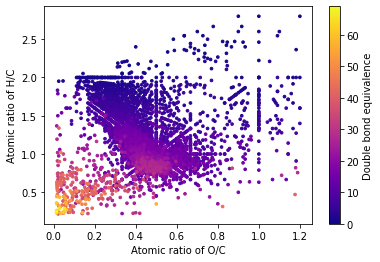

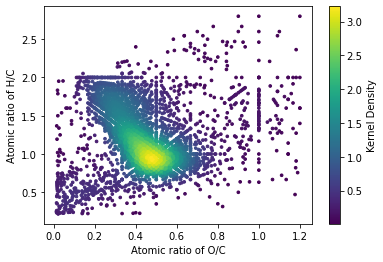

In [14]:
#Here we make a van Krevelen style plot where the y axis represents N/C values, and colour code the points by double bond equivalence 
plt.figure()
pk.van_krevelen_plot(A, y_ratio = 'HC',c = dbe,s = 7, cmap = 'plasma') #van_krevele_plot takes any keyword arguments that can be passed to pyplot.scatter() 
cbar = plt.colorbar() #add a colour bar 
cbar.set_label('Double bond equivalence')
plt.grid(False)
#PyKrev.van_krevelen_plot can take the value 'density' for the key word argument 'c' to colour code points based on kernel density
plt.figure()
pk.van_krevelen_plot(A ,c='density',s = 7)
plt.colorbar().set_label('Kernel Density')
plt.grid(False)

2.3: [**Kendrick mass defect plots**](https://doi.org/10.1021/acs.analchem.9b03333) are a useful way to identify chemically related compounds based on exact measurements. With pykrev you can make them using **```kendrick_mass_defect_plot```**.

(250.0, 1000.0)

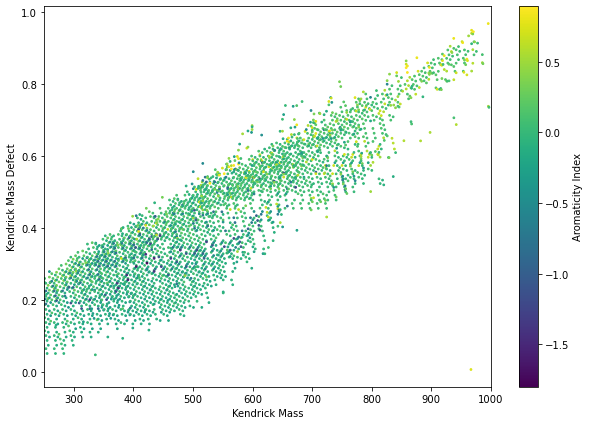

In [15]:
plt.figure(figsize = (10,7))
fig, ax ,(kendrickMass, kendrickMassDefect) = pk.kendrick_mass_defect_plot(A, base = 'CH2', rounding = 'ceil', s = 3, c = ai)
plt.colorbar().set_label('Aromaticity Index')
plt.xlim([250,1000])

<h3> 실험데이터로 해보기 </h3>

In [16]:
my_tuple = pk.read_csv('data/Example 3.csv', column_headers = True) 

In [17]:
my_tuple = my_tuple.filter_spectral_interference(tol=2)

211 interferences removed.


In [18]:
dbe = pk.double_bond_equivalent(my_tuple)

In [19]:
len(dbe)

1311

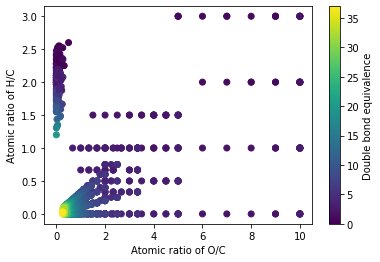

In [20]:
plt.figure()
pk.van_krevelen_plot(my_tuple,y_ratio = 'HC',c = dbe)
plt.colorbar().set_label('Double bond equivalence')
plt.grid(False)

In [21]:
kendrickMass, kendrickMassDefect = pk.kendrick_mass_defect(my_tuple, base = ['F'], rounding = 'even') 

In [22]:
ai = pk.aromaticity_index(my_tuple, index_type = 'rAI') 

Warning Zero Division Encountered, NaN value returned. {'C': 0, 'H': 1, 'N': 1, 'O': 5, 'P': 0, 'S': 0, 'Cl': 0, 'F': 0}
Warning Zero Division Encountered, NaN value returned. {'C': 0, 'H': 0, 'N': 0, 'O': 6, 'P': 0, 'S': 0, 'Cl': 0, 'F': 0}
Warning Zero Division Encountered, NaN value returned. {'C': 0, 'H': 3, 'N': 1, 'O': 5, 'P': 0, 'S': 0, 'Cl': 0, 'F': 0}
Warning Zero Division Encountered, NaN value returned. {'C': 0, 'H': 3, 'N': 1, 'O': 5, 'P': 0, 'S': 0, 'Cl': 0, 'F': 0}
Warning Zero Division Encountered, NaN value returned. {'C': 0, 'H': 2, 'N': 0, 'O': 6, 'P': 0, 'S': 0, 'Cl': 0, 'F': 0}
Warning Zero Division Encountered, NaN value returned. {'C': 0, 'H': 2, 'N': 0, 'O': 6, 'P': 0, 'S': 0, 'Cl': 0, 'F': 0}
Warning Zero Division Encountered, NaN value returned. {'C': 0, 'H': 2, 'N': 0, 'O': 6, 'P': 0, 'S': 0, 'Cl': 0, 'F': 0}
Warning Zero Division Encountered, NaN value returned. {'C': 0, 'H': 2, 'N': 0, 'O': 6, 'P': 0, 'S': 0, 'Cl': 0, 'F': 0}
Warning Zero Division Encountere

(250.0, 1000.0)

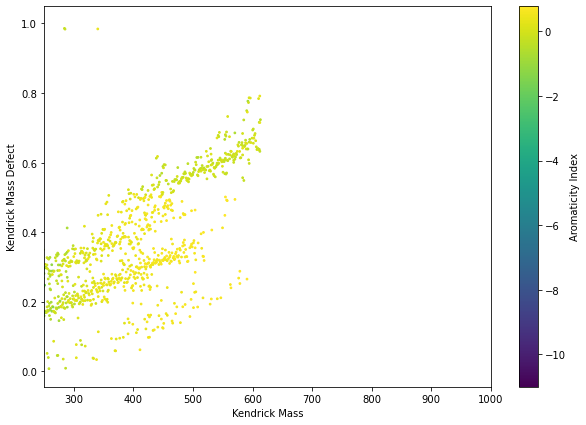

In [23]:
plt.figure(figsize = (10,7))
fig, ax ,(kendrickMass, kendrickMassDefect) = pk.kendrick_mass_defect_plot(my_tuple, base = 'CH2', rounding = 'ceil', s = 3, c = ai)
plt.colorbar().set_label('Aromaticity Index')
plt.xlim([250,1000])